The purpose of this notebook is to map the BRM short names to the BIM/EIM. 

Author: James Hicks
Date: 11/9/2021

INPUT:
1. The BRM dataset (see brmFileName)

In [116]:
#imports
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import plotly.express as px
import textwrap

In [117]:
#variables

#input file name
brmFileName='BRM 7.0.xlsx'

#duplicate name string 
duplicatedName='Research Proposals'
duplicatedConcatValues=['Write ','Evaluate ']


#the following iFAM numbers have a missing 0 from excel and need to be added
addZeroList=['MEM001','TRT001']

In [118]:
#read in data
brmRawData=pd.read_excel(brmFileName)

In [119]:
#necessary column names for our work
brmColNames=['VA BRM Number','VA BRM Short Name','Level','iFAM Number']

#make a copy to edit
brmData=copy.deepcopy(brmRawData[brmColNames])
#type cast to str
brmData=brmData.astype(str)

#==========BRM ADD MISSING 0'S ========= THIS CAN PROBABLY BE DELETED/COMMENTED OUT IN PALENTIR
#get the rows that are known to have the dropped 0 problem by iFAM number
rowsToChange=copy.deepcopy(brmData[brmData['iFAM Number'].isin(addZeroList)])
#add the 0
rowsToChange['VA BRM Number']=rowsToChange['VA BRM Number']+'0'
#remove the originals
brmData=brmData[~brmData['iFAM Number'].isin(addZeroList)]
#append the fixed rows
brmData=brmData.append(rowsToChange,ignore_index=True)


In [120]:
#filter to only get levels of interest
levelValues=['Capability','Service']#parent, child
brmData=brmData[brmData['Level'].isin(levelValues)]

In [121]:
#declare dataset of parents
capabilityData=brmData[brmData['Level']==levelValues[0]]

In [122]:
#declare dataset of children
serviceData=brmData[brmData['Level']==levelValues[1]]

In [123]:
#find the index of the repeated values
repeatIndexList=list(serviceData.index[serviceData['VA BRM Short Name']==duplicatedName])

[180, 183]

In [124]:
#fix the duplicated name by appending the full name to it
serviceData.at[repeatIndexList[0],'VA BRM Short Name']=duplicatedConcatValues[0]+duplicatedName
serviceData.at[repeatIndexList[1],'VA BRM Short Name']=duplicatedConcatValues[1]+duplicatedName

In [150]:
#this chunk maps the parents to the children

data=[]#this is used to hold values and convert into the final dataframe of mapped values
#for each capability, get all of the children and put into the relationshipDf
fullParentList=[]
for i,row in capabilityData.iterrows():#for each capability
    tempBrm=row[0]
    tempParentName=row[1]#get the brm and name
    #now use the BRM # to get the rows in 
    tempKids=serviceData[serviceData['VA BRM Number'].str.startswith(tempBrm+'.')]#add the . to finalize the parent
    #for example, search 1.1.etc will not find 1.10.etc
    #data.append([tempParentName,'']) # if this line gets uncommented it will add in a row for each parent
    #for each row of the kids get generate a list that maps parent to child text
    fullParentList.append(tempParentName)
    for i2,row2 in tempKids.iterrows():#add a row for each child
        tempShort=row2[1]
        tempList=[tempShort,tempParentName]
        data.append(tempList)
    
#combine all of the rows into a dataframe
relationshipDf=pd.DataFrame(data, columns=['Name','Parent'])

In [151]:
#add in a value column to make each square the same size

parentList=list(relationshipDf['Parent'].unique())
valueList=[1]*len(relationshipDf)

#the loop below converts the parent rows (if applicable) to no value 
#for i in range(0,len(parentList)):
#    if(parentList[i]==''):
#        valueList[i]=''
relationshipDf['value']=valueList


In [155]:
#for each parent check to see if extra boxes are necessary
for currentParent in fullParentList:
    tempData=relationshipDf[relationshipDf['Parent']==currentParent]
    tempNKids=len(tempData)
    if(tempNKids==0 or tempNKids%2==1):
        tempData={'Name':"",'Parent':currentParent,'value':1}
        relationshipDf=relationshipDf.append(tempData,ignore_index=True)

In [156]:
#try to fix the text wrap by adding in new lines
relationshipDf['Name']=relationshipDf['Name'].str.replace(' ','<br>')#replace spaces with html breakline
#add color column
relationshipDf['Color']='blue'

In [164]:
#make a dictionary with a color for each parent that is static
#color_discrete_map={'(?)':'lightgrey', 'Lunch':'gold', 'Dinner':'darkblue'}
colorDict={key: "lightgrey" for key in fullParentList}
colorDict['(?)']='lightgrey'
##c8dbd9

In [182]:
#sorting has no effect on where the boxes go - I think it's alphabetical?

fig=px.treemap(relationshipDf,path=['Parent','Name'],values='value',title ='BRM to BIM',color='Color',color_discrete_map=colorDict)
fig.update_traces(root_color='lightblue')
#fig.update_layout(treemapcolorway=['blue'])
fig.update_layout(uniformtext=dict(minsize=12, mode='show'))
fig.update_layout(autosize=False,width=1650,height=800)

# to export use the line below. Scale = resolution. if <1 it decreases dimensonality. >1 increases
#fig.write_image('figure.png', scale=2)
 
fig.show()

fig.write_html('test.html')

In [15]:
#output the csv to use for d3 - this is not in use currently

#relationshipDf.to_csv('BRM Tree Data.csv',sep=',',index=False,encoding='utf-8')

In [136]:
test=px.data.tips().head()
test['time'].unique()

array(['Dinner'], dtype=object)

In [16]:
#create a function to find the order from least to greatest # of chars 
#need to account for length of kids AND length of parent name for the comparison

In [ ]:
#current parents with no children - manually validated 
# Legal Guidance & Representation - ok
# Coordinate Homeless Program - ok 
# Veterans Employment & Retention - ok

In [138]:
parentList

0                      Process Benefit
1                      Process Benefit
2                      Process Benefit
3                      Process Benefit
4                    Health Care Admin
                    ...               
126    Travel, Relocation & Fleet Mgmt
127    Travel, Relocation & Fleet Mgmt
128    Travel, Relocation & Fleet Mgmt
129    Travel, Relocation & Fleet Mgmt
130    Travel, Relocation & Fleet Mgmt
Name: Parent, Length: 131, dtype: object

In [17]:
#get the length of all children 
data=[]
for currentParent in parentList:#for each parent
    tempData=relationshipDf[relationshipDf['Parent']==currentParent]
    tempNKids=len(tempData)
    tempNames=list(tempData['Name'])
    tempSum=sum(len(s) for s in tempNames)
    tempLen=tempSum+tempNKids*2 #for now, the margin is tempNKids * 2 - can be updated later
    
    tempList=[currentParent,tempNKids,tempSum,tempLen]
    data.append(tempList)
sortedParents=pd.DataFrame(data, columns=['ParentName','NKids','LenNames','TotalLen'])

#for i,row in relationshipDf.iterrows():#for each row

In [19]:
sortedParents=sortedParents.sort_values('TotalLen')

In [20]:
#save the sorted parents for Richard 
sortedParents.to_csv('BIM Parents Sorted.csv',sep=',',index=False,encoding='utf-8')

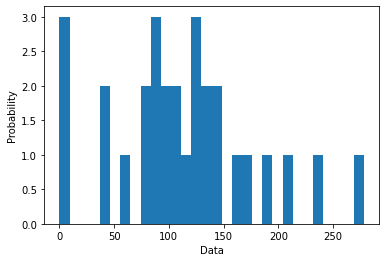

In [25]:
plt.hist(list(sortedParents['TotalLen']), density=False, bins=30)  
plt.ylabel('Probability')
plt.xlabel('Data');

In [40]:
#this loop will generate the rectangles later on 
#later on it needs one row vs multirow logic. currently one row

for currentParent in list(sortedParents['ParentName']):#for each parent (A<B order)
    #get the set of children
    tempData=relationshipDf[relationshipDf['Parent']==currentParent]
    if(len(tempData)>0):#if there are children
        tempSortedData=list(sortedParents.loc[sortedParents['ParentName']==currentParent].iloc[0])
        #print(tempSortedData)
    #print(currentParent,len(tempData))
    #========data variables
    parentLen=len(currentParent)
    
    #========Plot variables
    #parentRect represents the rectangle size that we are calculating now.
    parentRect=[0,0]#x,y
    #this value represents how large the padding is between text and the edge of a shape
    textPadding=.1
    #this value represents how tall text is
    textHeight=.5
    #this value is to scale the number of characters into an x value
    charConstant=.8
    #this value is the width of the column
    colWidth=2
    #this value is the height of the column
    colHeight=3
    #0 kids
    
    #===========parent rectangle size
    if(tempNKids==0):
        parentRect[0]=charConstant*parentLen # x if no kids, base it on parent name 
        parentRect[1]=textHeight+textPadding # y
    else:#>0 kids
        #need to figure out if this is one long row or stacked rows later on
        parentRect[0]=tempSortedData[3]*charConstant# x = sum of all character length + 2 char padding
        parentRect[1]=textHeight+textPadding # y
    
    print(parentRect)
    

[27.8, 0.6]
[27.8, 0.6]
[27.8, 0.6]
[3.8000000000000003, 0.6]
[4.6000000000000005, 0.6]
[6.0, 0.6]
[7.7, 0.6]
[8.200000000000001, 0.6]
[8.8, 0.6]
[8.8, 0.6]
[8.9, 0.6]
[9.3, 0.6]
[9.4, 0.6]
[10.3, 0.6]
[10.600000000000001, 0.6]
[11.9, 0.6]
[12.100000000000001, 0.6]
[12.100000000000001, 0.6]
[12.200000000000001, 0.6]
[13.3, 0.6]
[13.700000000000001, 0.6]
[14.3, 0.6]
[14.700000000000001, 0.6]
[16.2, 0.6]
[16.8, 0.6]
[18.6, 0.6]
[20.6, 0.6]
[24.0, 0.6]
[27.8, 0.6]


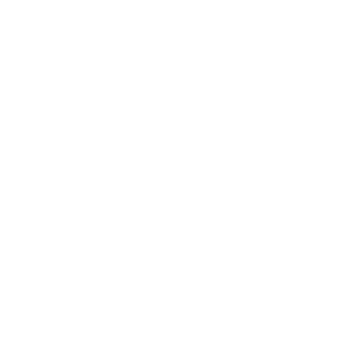

In [4]:
plt.figure(figsize=[8, 6],dpi=80)
plt.title('Business Information Model')
plt.axis('off')
plt.show()